In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

In [ ]:
# ! pip install xgboost

In [2]:
def score_dataset(X, y, model=XGBRegressor(random_state=0)):
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_absolute_error",
    )

    return -score.mean()

In [3]:
df = pd.read_csv("/content/ames.csv")

In [4]:
df.describe()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,FirstFlrSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,Threeseasonporch,ScreenPorch,PoolArea,MiscVal,MoSold,YearSold,SalePrice
count,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,...,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,57.647782,10147.921843,1971.356314,1984.266553,101.096928,4.177474,49.705461,559.071672,1051.255631,1159.557679,...,93.751877,47.533447,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,180796.060068
std,33.499441,7880.017759,30.245361,20.860286,178.634545,2.233372,169.142089,439.540571,440.968018,391.890885,...,126.361562,67.483400,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,79886.692357
min,0.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,43.000000,7440.250000,1954.000000,1965.000000,0.000000,3.000000,0.000000,219.000000,793.000000,876.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000
50%,63.000000,9436.500000,1973.000000,1993.000000,0.000000,3.000000,0.000000,465.500000,990.000000,1084.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,78.000000,11555.250000,2001.000000,2004.000000,162.750000,7.000000,0.000000,801.750000,1301.500000,1384.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213500.000000
max,313.000000,215245.000000,2010.000000,2010.000000,1600.000000,7.000000,1526.000000,2336.000000,6110.000000,5095.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


## Выбор фич для PCA

In [5]:
df.corrwith(df.SalePrice, numeric_only=True).sort_values()

BsmtFinSF1         -0.134905
EnclosedPorch      -0.128787
KitchenAbvGr       -0.119814
LowQualFinSF       -0.037660
BsmtHalfBath       -0.035817
YearSold           -0.030569
MiscVal            -0.015691
BsmtFinSF2          0.006018
Threeseasonporch    0.032225
MoSold              0.035259
PoolArea            0.068403
ScreenPorch         0.112151
BedroomAbvGr        0.143913
BsmtUnfSF           0.183308
LotFrontage         0.201875
LotArea             0.266549
SecondFlrSF         0.269373
BsmtFullBath        0.275823
HalfBath            0.285056
OpenPorchSF         0.312951
WoodDeckSF          0.327143
Fireplaces          0.474558
TotRmsAbvGrd        0.495474
MasVnrArea          0.502196
YearRemodAdd        0.532974
FullBath            0.545604
YearBuilt           0.558426
FirstFlrSF          0.621676
TotalBsmtSF         0.632529
GarageArea          0.640138
GarageCars          0.647562
GrLivArea           0.706780
SalePrice           1.000000
dtype: float64

In [6]:
features = [
    "GarageArea",
    "YearBuilt",
    "TotalBsmtSF",
    "GrLivArea",
]

print("Correlation with SalePrice:\n")
print(df[features].corrwith(df.SalePrice))

Correlation with SalePrice:

GarageArea     0.640138
YearBuilt      0.558426
TotalBsmtSF    0.632529
GrLivArea      0.706780
dtype: float64


## Применение PCA

In [7]:
X = df.copy()
y = X.pop("SalePrice")
X = X.loc[:, features]

# Стандартизация
X_stand = (X - X.mean(axis=0)) / X.std(axis=0)

pca = PCA()
X_pca = pca.fit_transform(X_stand)

# Переводим результат в Pandas Dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)
# В loading записываем "смысловую нагрузку" компонент, их корреляцию с исходными
loadings = pd.DataFrame(
    pca.components_.T,
    columns=component_names,
    index=X.columns,
)

print(loadings)

                  PC1       PC2       PC3       PC4
GarageArea   0.546548 -0.035684 -0.424831  0.720784
YearBuilt    0.458738 -0.735865 -0.152473 -0.474146
TotalBsmtSF  0.517214  0.076507  0.845324  0.109835
GrLivArea    0.472582  0.671845 -0.285829 -0.493551


In [8]:
1, 1.5
1, 1

PCA = (1,1)

1*1 + 1*1.5 = 2.5
1*1 + 1*1 = 2

SyntaxError: ignored

## Интерпретация и оценка

In [9]:
X = df[features].copy()
y = df.SalePrice.copy()

X = X.join(X_pca.PC1)
X['Ground_size'] = X.TotalBsmtSF / X.GrLivArea

score = score_dataset(X, y)
print(score)

22725.34697432274


## Применение PCA для поиска выбросов

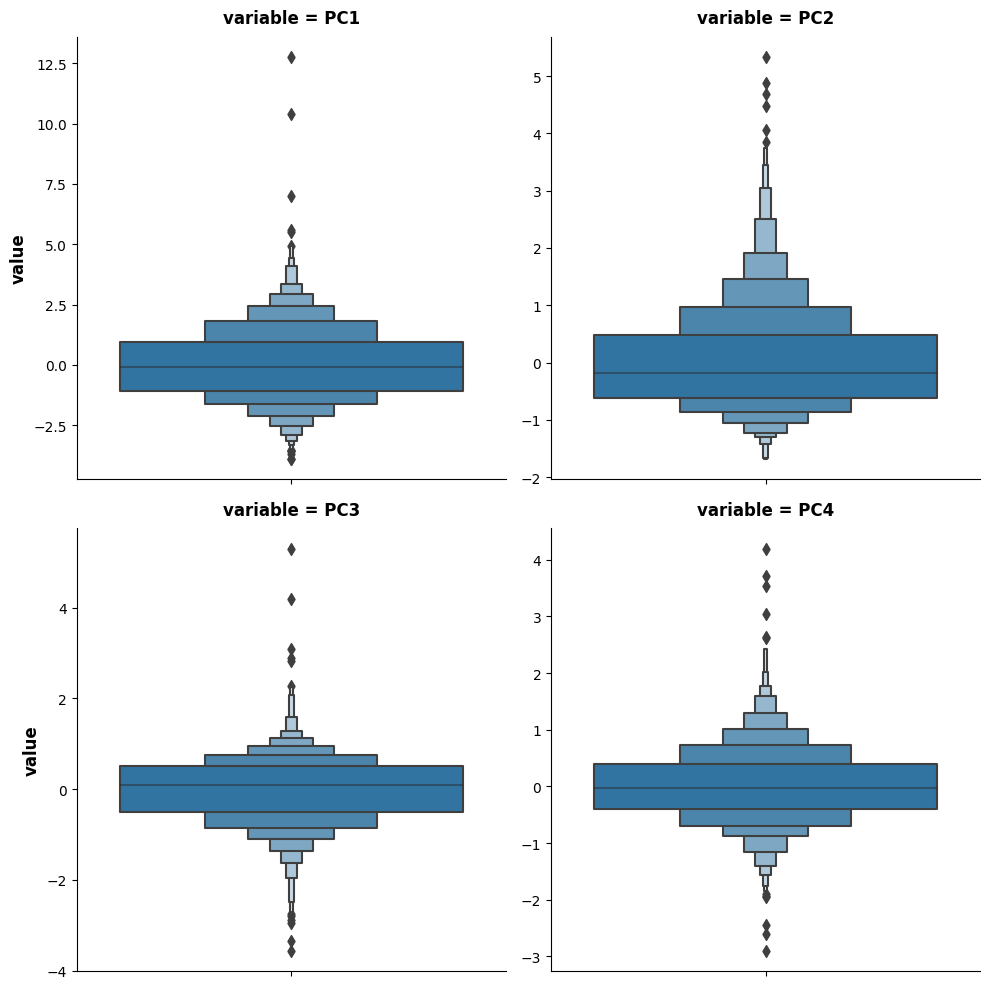

In [10]:
sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2,
);

In [11]:
component = "PC2"

idx = X_pca[component].sort_values(ascending=False).index
df.loc[idx, ["SalePrice", "SaleCondition"] + features]

,SalePrice,SaleCondition,GarageArea,YearBuilt,TotalBsmtSF,GrLivArea
1498,160000,Partial,1418.0,2008,6110.0,5642.0
1306,295000,Normal,870.0,1880,1470.0,3493.0
2666,475000,Normal,840.0,1892,1107.0,3608.0
2180,183850,Partial,1154.0,2008,5095.0,5095.0
2194,200000,Abnorml,0.0,1914,1440.0,3395.0
...,...,...,...,...,...,...
2803,155900,Normal,420.0,2004,848.0,848.0
1484,144500,Normal,420.0,2004,848.0,848.0
1482,141000,Normal,420.0,2004,848.0,848.0
1481,149300,Normal,420.0,2004,848.0,848.0


## Дисперсия, объясняемая PCA

[None, None]

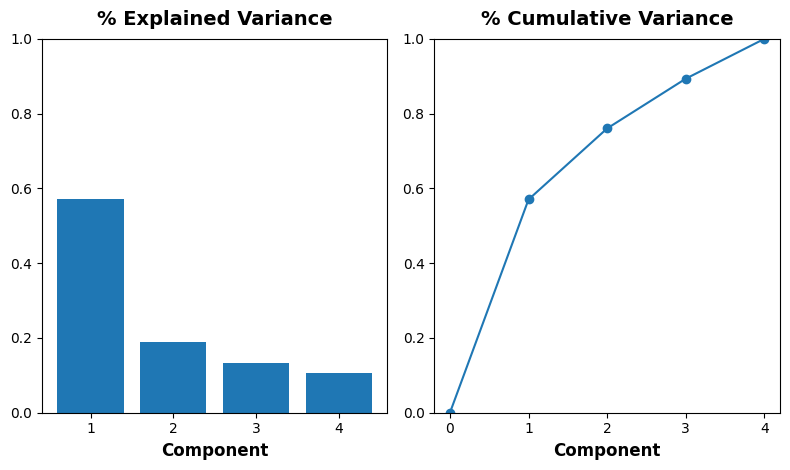

In [12]:
fig, axs = plt.subplots(1, 2)
n = pca.n_components_
grid = np.arange(1, n + 1)

evr = pca.explained_variance_ratio_
axs[0].bar(grid, evr)
axs[0].set(xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0))

# Кумулятивная дисперсия (variance)
cv = np.cumsum(evr)
axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
axs[1].set(xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0))

fig.set(figwidth=8, dpi=100)